# Pointcloud Exploration

In this notebook we explore PointCloud objects with Open3D

In [1]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# RGBD image
color = o3d.io.read_image('img/pimenton/front_color_0.jpg')
depth = o3d.io.read_image('img/pimenton/front_depth_0.png')
rgbd_img = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color, depth, convert_rgb_to_intensity=False)
print(rgbd_img)

RGBDImage of size 
Color image : 640x480, with 3 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


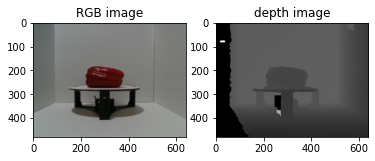

In [3]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.title('RGB image')
plt.imshow(rgbd_img.color)
plt.subplot(1, 2, 2)
plt.title('depth image')
plt.imshow(rgbd_img.depth, cmap='gray')
plt.show()

In [4]:
# read camera parameters

import json

with open('img/pimenton/calib_data_front.json') as json_file:
    cam_params = json.load(json_file)
cam_params

{'color intrinsics': {'coeffs': [0.0, 0.0, 0.0, 0.0, 0.0],
  'fx': 617.4967041015625,
  'fy': 617.2276611328125,
  'height': 480,
  'model': 'distortion.inverse_brown_conrady',
  'ppx': 318.59136962890625,
  'ppy': 252.50799560546875,
  'width': 640},
 'depth intrinsics': {'coeffs': [0.0, 0.0, 0.0, 0.0, 0.0],
  'fx': 600.8629760742188,
  'fy': 600.8629760742188,
  'height': 480,
  'model': 'distortion.brown_conrady',
  'ppx': 319.6057434082031,
  'ppy': 244.78125,
  'width': 640},
 'depth to color extrinsics': {'rotation': [0.9999845027923584,
   0.0017420530784875154,
   -0.005285933148115873,
   -0.0017585224704816937,
   0.999993622303009,
   -0.003112656995654106,
   0.0052804769948124886,
   0.003121904330328107,
   0.999981164932251],
  'translation': [0.015297875739634037,
   -3.996360464952886e-05,
   -0.0005155084654688835]}}

In [5]:
# create intrinsics object from depth
intrinsics = o3d.camera.PinholeCameraIntrinsic(cam_params['depth intrinsics']['width'],
                                               cam_params['depth intrinsics']['height'],
                                               cam_params['depth intrinsics']['fx'],
                                               cam_params['depth intrinsics']['fy'],
                                               cam_params['depth intrinsics']['ppx'],
                                               cam_params['depth intrinsics']['ppy'])
intrinsics.intrinsic_matrix

array([[600.86297607,   0.        , 319.60574341],
       [  0.        , 600.86297607, 244.78125   ],
       [  0.        ,   0.        ,   1.        ]])

In [6]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_img,
    intrinsics,
    project_valid_depth_only=True
)
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

PointCloud with 271008 points.

In [7]:
o3d.visualization.draw_geometries([pcd])

In [8]:
import numpy as np

np.asarray(pcd.points).shape

(271008, 3)

In [9]:
# another point cloud without discarding points
pcd_complete = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_img,
    intrinsics,
    project_valid_depth_only=False
)
# Flip it, otherwise the pointcloud will be upside down
pcd_complete.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

np.asarray(pcd_complete.points)

array([[        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       ...,
       [ 0.16903381, -0.12473726, -0.31999999],
       [ 0.16956638, -0.12473726, -0.31999999],
       [ 0.17009895, -0.12473726, -0.31999999]])

In [10]:
# create point cloud by hand represented as a 3 channel matrix (h, w, xyz)
def pcd_as_mat(depth_img, cam_params):
    # unpack params
    w = cam_params['depth intrinsics']['width']
    h = cam_params['depth intrinsics']['height']
    fx = cam_params['depth intrinsics']['fx']
    fy = cam_params['depth intrinsics']['fy']
    cx = cam_params['depth intrinsics']['ppx']
    cy = cam_params['depth intrinsics']['ppy']
    
    # auxiliary arrays to take into account the coordinate of the points
    u = np.arange(h).reshape(-1,1)
    v = np.arange(w).reshape(1,-1)
    
    # conversion factor to meters
    d_scale = 10000
    
    # compute channels
    z = np.asarray(depth_img) / d_scale
    x = (v - cx) * z/fx
    y = (u - cy) * z/fy
    
    # stack channels
    mat = np.stack((x, y, z), axis=-1)
    
    # map nan to 0
    mat = np.nan_to_num(mat)
    
    return mat

In [11]:
pcd_mat = pcd_as_mat(rgbd_img.depth, cam_params)
print(pcd_mat.shape, pcd_mat.dtype, sep='\n')

(480, 640, 3)
float64


In [12]:
# create o3d point cloud from matrix representation to visualize it
pcd_from_mat = o3d.geometry.PointCloud(
    o3d.utility.Vector3dVector(pcd_mat.reshape(-1, 3))
)
pcd_from_mat.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

PointCloud with 307200 points.

In [13]:
o3d.visualization.draw_geometries([pcd_from_mat])

In [14]:
# load another image to try substraction
color = o3d.io.read_image('img/pimenton/front_color_2.jpg')
depth = o3d.io.read_image('img/pimenton/front_depth_2.png')
rgbd_img_1 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color, depth, convert_rgb_to_intensity=False)
print(rgbd_img)

RGBDImage of size 
Color image : 640x480, with 3 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


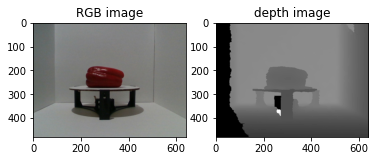

In [15]:
plt.subplot(1, 2, 1)
plt.title('RGB image')
plt.imshow(rgbd_img_1.color)
plt.subplot(1, 2, 2)
plt.title('depth image')
plt.imshow(rgbd_img_1.depth, cmap='gray')
plt.show()

In [16]:
pcd_mat_1 = pcd_as_mat(rgbd_img_1.depth, cam_params)
print(pcd_mat_1.shape, pcd_mat_1.dtype, sep='\n')

(480, 640, 3)
float64


1.7320508075688772 0.0


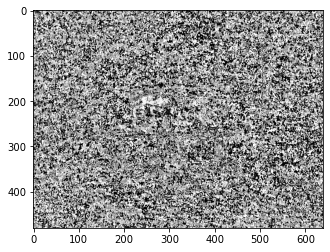

In [17]:
# color difference
color_diff = np.abs(np.asarray(rgbd_img.color) - np.asarray(rgbd_img_1.color)) / 255

# convert to one channel using sqrt of sum of squares 
color_diff = np.sqrt(np.sum(color_diff**2, axis=2))

print(color_diff.max(), color_diff.min())
plt.imshow(color_diff/color_diff.max(), cmap="gray")

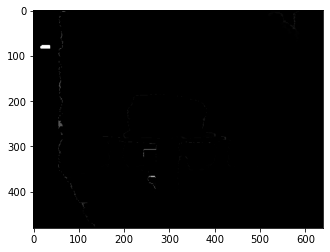

In [18]:
# pcd difference
depth_diff = np.abs(np.asarray(rgbd_img.depth) - np.asarray(rgbd_img_1.depth))

plt.imshow(depth_diff, cmap='gray')

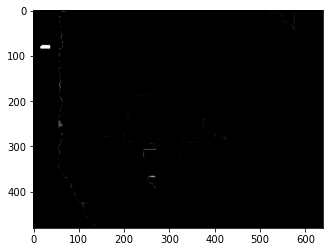

In [19]:
# pcd difference
pcd_diff = np.abs(pcd_mat - pcd_mat_1)
pcd_diff = np.sqrt(np.sum(pcd_diff**2, axis=2))

plt.imshow(pcd_diff, cmap='gray')